# Taxi Fare Prediction

In [183]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## import necessary modules

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from math import sqrt
from datetime import datetime

from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
import calendar

import folium

from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
from folium.plugins import TimestampedGeoJson
from folium.plugins import MarkerCluster

% matplotlib inline
plt.style.use('seaborn-whitegrid')

## Load Dataset

In [185]:
# df_train = pd.read_csv('/content/train_25k.csv', nrows=15000)
df_train = pd.read_csv('/content/drive/MyDrive/DataMiningProject/NYCTaxiFare_TrainData.csv', nrows=10000)
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [186]:
df_train.shape

(10000, 8)

In [187]:
df_train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [188]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,11.235464,-72.466660,39.920448,-72.474094,39.893281,1.644700
std,9.584258,10.609729,7.318932,10.579732,6.339919,1.271229
min,-2.900000,-74.438233,-74.006893,-74.429332,-73.994392,0.000000
25%,6.000000,-73.992058,40.734547,-73.991112,40.735230,1.000000
50%,8.500000,-73.981758,40.752693,-73.980083,40.753738,1.000000
75%,12.500000,-73.966925,40.767694,-73.963504,40.768186,2.000000
max,180.000000,40.766125,401.083332,40.802437,41.366138,6.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Fare Amount')

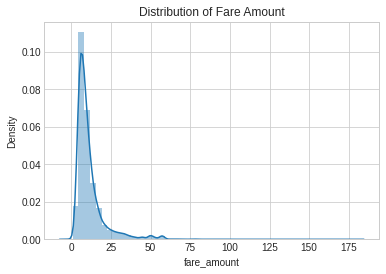

In [189]:
sns.distplot(df_train['fare_amount'])
plt.title('Distribution of Fare Amount')

## Data Cleaning

### Removing all the taxi trips which has negative fare amount.


In [190]:
#Remove data which has the fare amount negative.
print('Old size: %d' % len(df_train))
df_train = df_train[df_train.fare_amount>=0]
print('New size: %d' % len(df_train))

Old size: 10000
New size: 9998


### Removing taxi trips that have missing data.

In [191]:
#count of missing data with respect to attributes:
print(df_train.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [192]:
#Removing the records with missing data.
print('Old size: %d' % len(df_train))
df_train = df_train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(df_train))

Old size: 9998
New size: 9998


### Removing taxi trips those have passenger count less than zero and greater than six.

In [193]:
print('Old size: %d' % len(df_train))
df_train = df_train[df_train.passenger_count<=6]
df_train = df_train[df_train.passenger_count>0]
print('New size: %d' % len(df_train))

Old size: 9998
New size: 9960


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


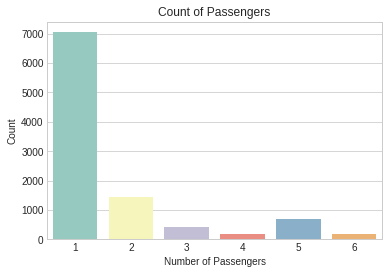

In [194]:
passenger = df_train.groupby(['passenger_count']).count()
sns.barplot(passenger.index, passenger['key'], palette = "Set3")
plt.xlabel('Number of Passengers')
plt.ylabel('Count')
plt.title('Count of Passengers')
plt.show()

In [195]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [196]:
def groupandplot(data,groupby_key,value,aggregate='mean'):
    #plt.figure(figsize=(16,10))
    agg_data=data.groupby([groupby_key])[value].agg(aggregate).reset_index().rename(columns={value:aggregate+'_'+value})
    #plt.subplot(1,2,1)
    #count_data=train_df.groupby([groupby_key])['key'].count().reset_index().rename(columns={'key':'Num_Trips'})
    #sns.barplot(x=groupby_key,y='Num_Trips',data=count_data).set_title("Number of Trips vs "+groupby_key)
    #plt.subplot(1,2,2)
    sns.barplot(x=groupby_key,y=aggregate+'_'+value,data=agg_data).set_title(aggregate+'_'+value+" vs "+groupby_key)

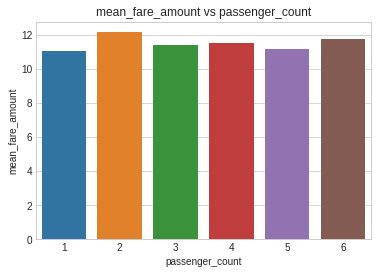

In [197]:
groupandplot(df_train,'passenger_count','fare_amount')

### Removing taxi trips having zero feature value which is not useful.

In [198]:
print('Old size: %d' % len(df_train))
df_train = df_train.loc[~(df_train == 0).any(axis=1)]
print('New size: %d' % len(df_train))

Old size: 9960
New size: 9764


### Converting the pickup_datetime attribute of type Object to different primitive types using lambda functions.

In [199]:
df_train['pickup_datetime']=pd.to_datetime(df_train['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')

df_train['pickup_date']= df_train['pickup_datetime'].dt.date
df_train['pickup_day']=df_train['pickup_datetime'].apply(lambda x:x.day)
df_train['pickup_hour']=df_train['pickup_datetime'].apply(lambda x:x.hour)
df_train['pickup_day_of_week']=df_train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
df_train['pickup_month']=df_train['pickup_datetime'].apply(lambda x:x.month)
df_train['pickup_year']=df_train['pickup_datetime'].apply(lambda x:x.year)

### Statistical Visualizations using Matplotlib

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count of Taxi Rides per Day of Week')

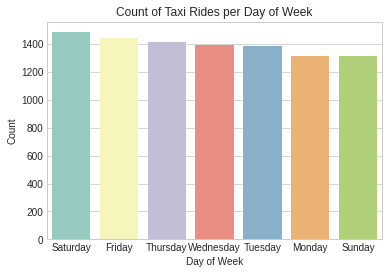

In [200]:
day_count = df_train.groupby(['pickup_day_of_week']).count().sort_values(by = 'key', ascending = False)
sns.barplot(day_count.index, day_count['key'], palette = "Set3")
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.title('Count of Taxi Rides per Day of Week')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count of Taxi Rides per Day of Month')

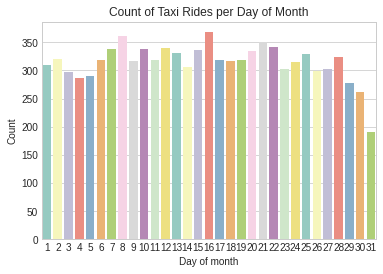

In [201]:
day_count = df_train.groupby(['pickup_day']).count().sort_values(by = 'key', ascending = False)
sns.barplot(day_count.index, day_count['key'], palette = "Set3")
plt.xlabel('Day of month')
plt.ylabel('Count')
plt.title('Count of Taxi Rides per Day of Month')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Average Fare Amount per Day of Week')

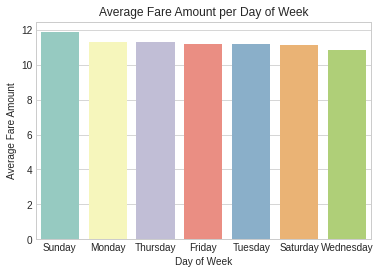

In [202]:
day_fare = df_train.groupby(['pickup_day_of_week']).mean().sort_values(by = 'fare_amount', ascending = False)

sns.barplot(day_fare.index, day_fare.fare_amount, palette = "Set3")

plt.xlabel('Day of Week')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount per Day of Week')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count of Total Rides Given During Each Day')

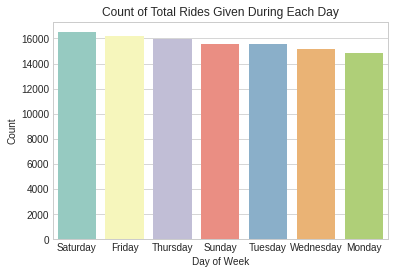

In [203]:
day_sum = df_train.groupby(['pickup_day_of_week']).sum().sort_values(by = 'fare_amount', ascending = False)

sns.barplot(day_sum.index, day_sum.fare_amount, palette = "Set3")

plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.title('Count of Total Rides Given During Each Day')

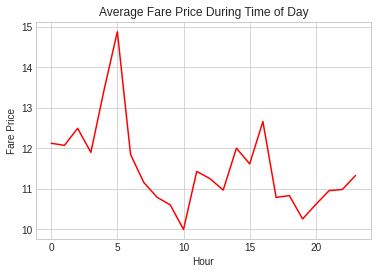

In [204]:
time_of_day = df_train.groupby(['pickup_hour']).mean()
plt.plot(time_of_day.index, time_of_day.fare_amount, color = 'r')
plt.xlabel('Hour')
plt.ylabel('Fare Price')
plt.title('Average Fare Price During Time of Day')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


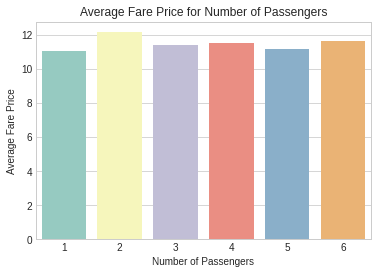

In [205]:
passenger_fare = df_train.groupby(['passenger_count']).mean()
sns.barplot(passenger_fare.index, passenger_fare['fare_amount'], palette = "Set3")
plt.xlabel('Number of Passengers')
plt.ylabel('Average Fare Price')
plt.title('Average Fare Price for Number of Passengers')
plt.show()

In [206]:
#let us convert day of the week to int datatyp
def encodeDays(day_of_week):
    day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]

In [207]:
df_train['pickup_day_of_week']=df_train['pickup_day_of_week'].apply(lambda x:encodeDays(x))

In [208]:
df_train.dtypes

key                           object
fare_amount                  float64
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
pickup_date                   object
pickup_day                     int64
pickup_hour                    int64
pickup_day_of_week             int64
pickup_month                   int64
pickup_year                    int64
dtype: object

In [209]:
#dropping the unnecessary data
df_train = df_train.drop(['key','pickup_datetime','pickup_date'], axis=1)
df_train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,15,17,1,6,2009
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5,16,2,1,2010
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,18,0,4,8,2011
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,21,4,6,4,2012
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,9,7,2,3,2010


### Location Data

In [210]:
# this function will also be used with the test set below
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            
# load image of NYC map
BB = (-74.4729, -72.7987, 40.4901, 41.8138)
BB = (-74.5, -72.8, 40.5, 41.8)
# nyc_map = plt.imread('nymapzout.png')

In [211]:
print('Old size: %d' % len(df_train))
df_train = df_train[select_within_boundingbox(df_train, BB)]
print('New size: %d' % len(df_train))

Old size: 9764
New size: 9749


In [212]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

In [213]:
# # plot training data on map
# plot_on_map(df_train, BB, nyc_map, s=1, alpha=0.3)

In [214]:
# # plot test data on map
# plot_on_map(df_test, BB, nyc_map, alpha=1.0, s=10)

### This is how the dataset looks after initial analysis and feature engineering on the pickup_date_time

In [215]:
df_train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,15,17,1,6,2009
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5,16,2,1,2010
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,18,0,4,8,2011
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,21,4,6,4,2012
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,9,7,2,3,2010


### Calculate distance between coordinates with the hypothesis being fare increases with increase in distance

In [216]:
def distance(lat1, lat2, lon1, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [218]:
df_train['trip_distance']=df_train.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude']
                                                             ,row['pickup_longitude'],row['dropoff_longitude']),axis=1)

Text(0.5, 1.0, 'Distribution of Trip Distance (log scale)')

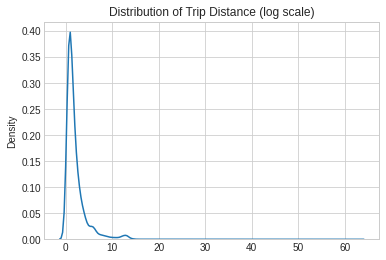

In [219]:
sns.kdeplot(df_train['trip_distance'].values).set_title("Distribution of Trip Distance (log scale)")

Text(17.925000000000004, 0.5, 'Taxi Fare')

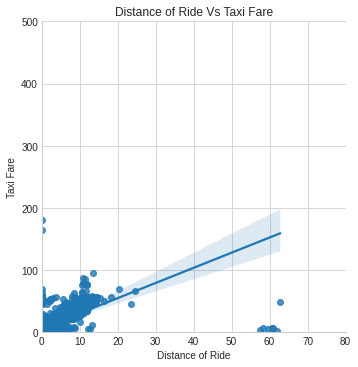

In [220]:
a_plot=sns.lmplot(x='trip_distance', y='fare_amount',data=df_train)
a_plot.set(xlim=(0, 80))
a_plot.set(ylim=(0, 500))

plt.title('Distance of Ride Vs Taxi Fare')
# Set x-axis label
plt.xlabel('Distance of Ride')
# Set y-axis label
plt.ylabel('Taxi Fare')

In [221]:
df_train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,trip_distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,15,17,1,6,2009,0.640487
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5,16,2,1,2010,5.250670
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,18,0,4,8,2011,0.863411
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,21,4,6,4,2012,1.739386
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,9,7,2,3,2010,1.242218


In [222]:
long_trips=df_train[df_train['trip_distance']>=50]

### Fetching NYC coordinates and dividing the city into burroughs which provides us with new features being pickup and dropoff burroughs

In [223]:
nyc_boroughs={
    'manhattan':{
        'min_lng':-74.0479,
        'min_lat':40.6829,
        'max_lng':-73.9067,
        'max_lat':40.8820
    },
    'queens':{
        'min_lng':-73.9630,
        'min_lat':40.5431,
        'max_lng':-73.7004,
        'max_lat':40.8007

    },
    'brooklyn':{
        'min_lng':-74.0421,
        'min_lat':40.5707,
        'max_lng':-73.8334,
        'max_lat':40.7395

    },
    'bronx':{
        'min_lng':-73.9339,
        'min_lat':40.7855,
        'max_lng':-73.7654,
        'max_lat':40.9176

    },
    'staten_island':{
        'min_lng':-74.2558,
        'min_lat':40.4960,
        'max_lng':-74.0522,
        'max_lat':40.6490 
    }  
}

In [224]:
def getBorough(lat,lng):
    
    locs=nyc_boroughs.keys()
    for loc in locs:
        if lat>=nyc_boroughs[loc]['min_lat'] and lat<=nyc_boroughs[loc]['max_lat'] and lng>=nyc_boroughs[loc]['min_lng'] and lng<=nyc_boroughs[loc]['max_lng']:
            return loc
    return 'others'

In [226]:
df_train['pickup_borough']=df_train.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
df_train['dropoff_borough']=df_train.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

### Statistical analysis of burroughs by count and also the average fare amount and distance across each burrough

Text(0.5, 1.0, 'Distribution of Pickup Boroughs')

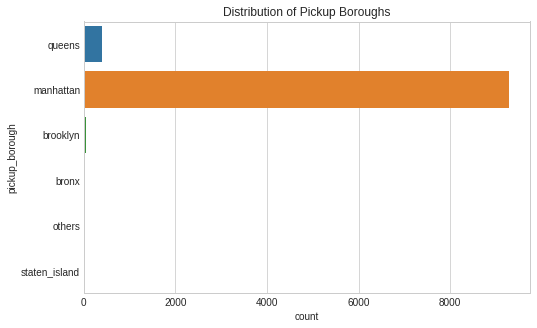

In [227]:
plt.figure(figsize=(8,5))
sns.countplot(y=df_train['pickup_borough'])
plt.title("Distribution of Pickup Boroughs")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


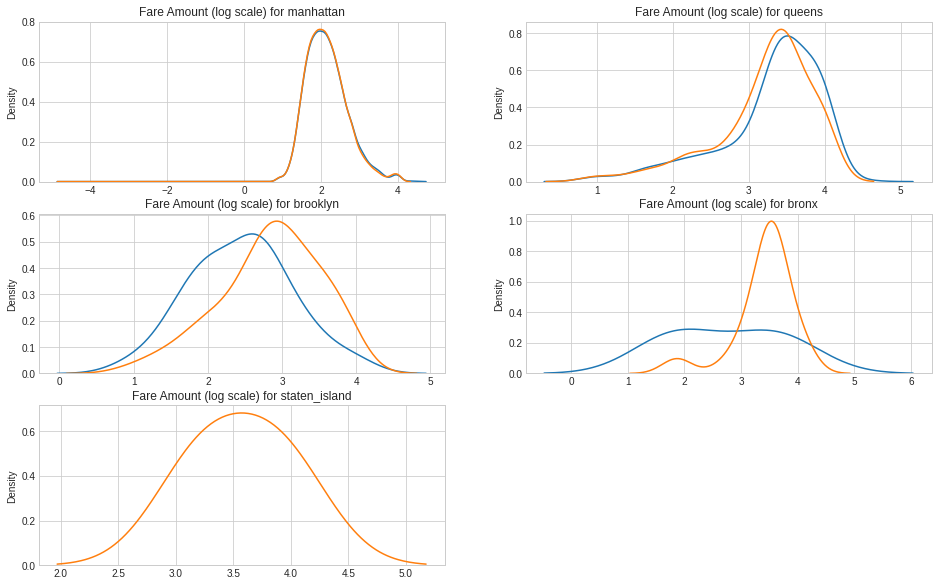

In [228]:
plt.figure(figsize=(16,10))
plt.title("Distribution of Fare Amount Across Buroughs")
i=1
for key in nyc_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot(np.log(df_train.loc[df_train['pickup_borough']==key,'fare_amount'].values),label='Pickup '+ key)
    sns.kdeplot(np.log(df_train.loc[df_train['dropoff_borough']==key,'fare_amount'].values),label='Dropoff'+ key).set_title("Fare Amount (log scale) for "+key)
    i=i+1

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


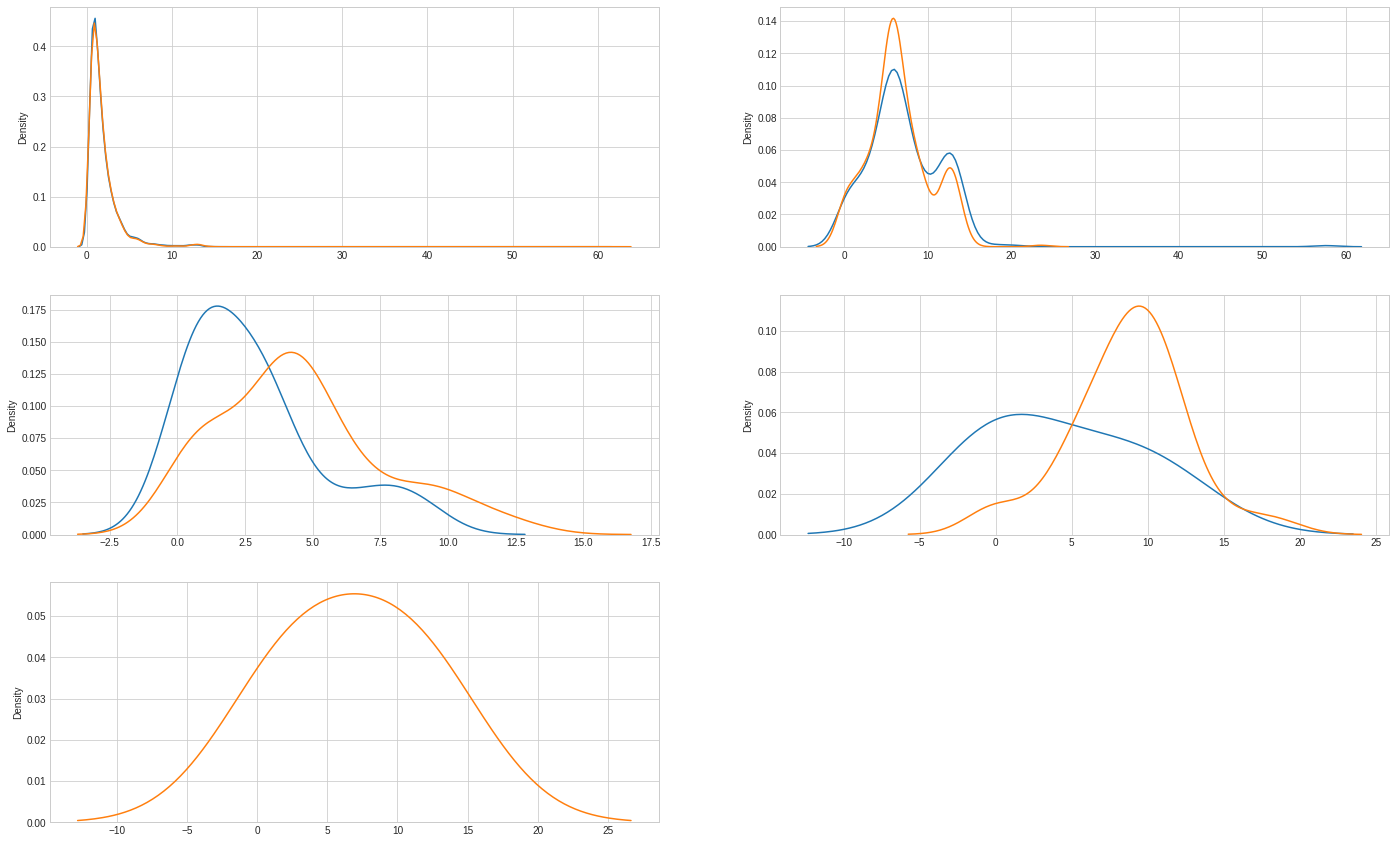

In [229]:
plt.figure(figsize=(24,15))
plt.title("Distribution of Trip Distances Across Buroughs")
i=1
for key in nyc_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot(df_train.loc[df_train['pickup_borough']==key,'trip_distance'].values,label='Pickup '+ key)
    sns.kdeplot(df_train.loc[df_train['dropoff_borough']==key,'trip_distance'].values,label='Dropoff'+ key).set_title
    ("Trip Distance (log) for "+key)
    i=i+1

In [230]:
lower_manhattan_boundary={'min_lng': -74.0194,
                          'min_lat':40.6997,
                          'max_lng':-73.9716,
                          'max_lat':40.7427}

def isLowerManhattan(lat,lng):
    if lat>=lower_manhattan_boundary['min_lat'] and lat<=lower_manhattan_boundary['max_lat'] and lng>=lower_manhattan_boundary['min_lng'] and lng<=lower_manhattan_boundary['max_lng']:
        return 1
    else:
        return 0

In [231]:
df_train['is_pickup_lower_manhattan']=df_train.apply(lambda row:isLowerManhattan(row['pickup_latitude'],row['pickup_longitude']),axis=1)
df_train['is_dropoff_lower_manhattan']=df_train.apply(lambda row:isLowerManhattan(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

In [232]:
df_train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,trip_distance,pickup_borough,dropoff_borough,is_pickup_lower_manhattan,is_dropoff_lower_manhattan
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,15,17,1,6,2009,0.640487,queens,queens,0,0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5,16,2,1,2010,5.250670,manhattan,manhattan,1,0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,18,0,4,8,2011,0.863411,manhattan,manhattan,0,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,21,4,6,4,2012,1.739386,manhattan,manhattan,1,0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,9,7,2,3,2010,1.242218,manhattan,manhattan,0,0


### Dividing trips by pickup and dropoff to airports as it was found that some coordinates having constant fare amount were the 3 airports in and around NYC

In [233]:
nyc_airports={'JFK':{'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659},   
    'EWR':{'min_lng':-74.1925,
            'min_lat':40.6700, 
            'max_lng':-74.1531, 
            'max_lat':40.7081
        },
    'LaGuardia':{'min_lng':-73.8895, 
                  'min_lat':40.7664, 
                  'max_lng':-73.8550, 
                  'max_lat':40.7931  
    }
}

def isAirport(latitude,longitude,airport_name='JFK'):
    
    if latitude>=nyc_airports[airport_name]['min_lat'] and latitude<=nyc_airports[airport_name]['max_lat'] and longitude>=nyc_airports[airport_name]['min_lng'] and longitude<=nyc_airports[airport_name]['max_lng']:
        return 1
    else:
        return 0

In [234]:
df_train['is_pickup_JFK']=df_train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
df_train['is_dropoff_JFK']=df_train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)

In [235]:
df_train['is_pickup_EWR']=df_train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
df_train['is_dropoff_EWR']=df_train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)

In [236]:
df_train['is_pickup_la_guardia']=df_train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
df_train['is_dropoff_la_guardia']=df_train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)

In [237]:
mean=np.mean(df_train['pickup_hour'].value_counts())
dev=np.std(df_train['pickup_hour'].value_counts())
taxi_count=df_train['pickup_hour'].value_counts()
m1=mean-dev
m2=mean+dev

In [238]:
from sklearn.preprocessing import LabelEncoder
 
number = LabelEncoder()
df_train["pickup_borough"] = number.fit_transform(df_train["pickup_borough"].astype('str'))
df_train["dropoff_borough"] = number.fit_transform(df_train["dropoff_borough"].astype('str'))
print(df_train.corr('pearson')["fare_amount"])

fare_amount                   1.000000
pickup_longitude              0.315821
pickup_latitude              -0.166495
dropoff_longitude             0.260317
dropoff_latitude             -0.140616
passenger_count               0.014306
pickup_day                   -0.002193
pickup_hour                  -0.034150
pickup_day_of_week           -0.016683
pickup_month                  0.040920
pickup_year                   0.099527
trip_distance                 0.698008
pickup_borough                0.451851
dropoff_borough               0.341466
is_pickup_lower_manhattan    -0.040435
is_dropoff_lower_manhattan   -0.085204
is_pickup_JFK                 0.402166
is_dropoff_JFK                0.323654
is_pickup_EWR                      NaN
is_dropoff_EWR                0.236048
is_pickup_la_guardia          0.281564
is_dropoff_la_guardia         0.236729
Name: fare_amount, dtype: float64


## Implementation of KNN Regression model

### Split Train, Test

In [247]:
X=df_train.drop(['fare_amount'],axis=1)
y=df_train['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [248]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7799, 21), (1950, 21), (7799,), (1950,))

### Custom Model

In [270]:
# vectorized distances from test
distances = np.sqrt(((X_train.to_numpy()[:, :, None] - X_test.to_numpy()[:, :, None].T) ** 2).sum(1))

In [272]:
# pick the nearest based on distances
sorted_distance = np.argsort(distances, axis = 0)

In [273]:
sorted_distance.shape

(7799, 1950)

#### KNN_Regression implementation from scratch

In [292]:
def KNN_Vectorized_Regressor(X_train,X_test,y_train,y_test,sorted_distance,k):
    y_pred = np.zeros(y_test.shape)
    for row in range(len(X_test)): 
        #Transforming the y_train values to adjust the scale. 
        y_pred[row] = y_train[sorted_distance[:, row][:k]].mean() 

    RMSE = np.sqrt(np.mean((y_test - y_pred)**2))

    correlation_matrix = np.corrcoef(y_test, y_pred)
    correlation_xy = correlation_matrix[0,1]
    r2 = correlation_xy**2

    return RMSE, r2

In [274]:
# Choosing the right K value
rmse_list = []
k_vals = range(3, 12)
for i in k_vals:
    rmse, r2 = KNN_Vectorized_Regressor(X_train.to_numpy(),X_test.to_numpy(),y_train.to_numpy(),y_test.to_numpy(),sorted_distance,i)
    rmse_list.append(rmse)

<Figure size 864x1152 with 0 Axes>

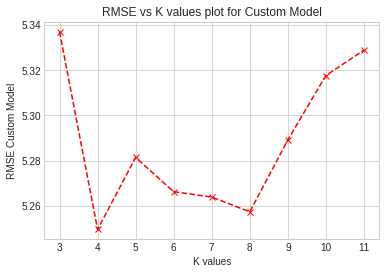

<Figure size 864x1152 with 0 Axes>

In [300]:
# Plot the RMSE
plt.plot(k_vals, rmse_list, color='red', marker='x', linestyle='dashed')
plt.title("RMSE vs K values plot for Custom Model")
plt.xlabel("K values")
plt.ylabel("RMSE Custom Model")
# plt.show()

#### Custom Model with right 'K'

In [285]:
K = 4
print(f"Running the model with K = {K}")
rmse, r2 = KNN_Vectorized_Regressor(X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy(), sorted_distance, K)
print(f"The r2_score of the Custom Model is {r2}")

Running the model with K = 4
The r2_score of the Custom Model is 0.677573229634383


### Sklearn model

#### Sklearn KNN Regression Model

In [286]:
from sklearn.neighbors import KNeighborsRegressor

sk_k_vals = range(3, 12)
sk_r2_val = []
sk_rmse_val = []

for K in sk_k_vals:
    model = KNeighborsRegressor(n_neighbors = K)    
    model.fit(X_train, y_train)
    pred=model.predict(X_test)

    sk_rmse_val.append(mean_squared_error(y_test, pred))
    sk_r2_val.append(r2_score(y_test, pred))

Text(0, 0.5, 'RMSE Sklearn Model')

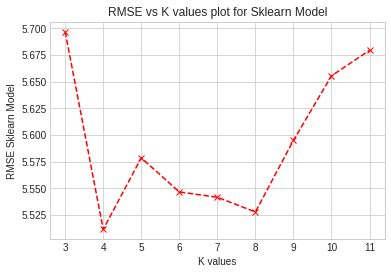

In [301]:
# Plot the RMSE
plt.plot(sk_k_vals, sk_rmse_val, color='red', marker='x', linestyle='dashed')
plt.title("RMSE vs K values plot for Sklearn Model")
plt.xlabel("K values")
plt.ylabel("RMSE Sklearn Model")

#### Sklearn model with right K

In [291]:
K = 4
print(f"Running the Sklearn model with K = {K}")
model = KNeighborsRegressor(n_neighbors = K)    
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(f"The r2_score of the Sklearn Model is {r2_score(y_test, pred)}")

Running the Sklearn model with K = 4
The r2_score of the Sklearn Model is 0.6693995420120449
